### Dependincies

In [1]:
# !pip install mediapipe opencv-python
# !pip install pandas
# !pip install openpyxl
# !pip install scipy
# !pip install fastdtw
# !pip install dtw
# !pip install dtaidistance

from dtw import dtw
import os #dosya okuma
import cv2 #video izleme
import mediapipe as mp #hareket tanımlama
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean 
from fastdtw import fastdtw
from scipy.signal import resample


Dosya yolu alma

In [2]:
def get_filename(path):
    # Dosya adını ve uzantısını ayrıştırın
    filename_with_ext = os.path.basename(path)
    
    # Uzantısız dosya adını döndürün
    return os.path.splitext(filename_with_ext)[0]

Trigonometrik olarak 3 noktadan açı değeri bulma

In [3]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 


Videodan dirsek açılarını hesaplama ve df kaydetme

In [4]:
def calculate__elbow_angles(video_path):
    angles = []
    
    # Setup mediapipe instance
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        
        # Open video file
        cap = cv2.VideoCapture(video_path)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Loop through each frame
        for i in range(length):
            ret, frame = cap.read()
            
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark

                # Get coordinates
                left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                left_whist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

                # Get coordinates
                right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
                right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
                right_whist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]


                # Calculate angle
                angle = calculate_angle(right_shoulder, right_elbow, right_whist)
                angles.append(round(angle,2))

            except:
                angles.append(None)

            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            cv2.imshow('Video', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        
        # Release video and close windows
        cap.release()
        cv2.destroyAllWindows()
        
        # Convert angles to dataframe
        df = pd.DataFrame(angles, columns=['Right_elbow Angle'])
        return df

Klasöre alınan verileri excel dosyasına yazdırma

In [5]:
def calculate_angles_all_videos(directory_path):
    videos = os.listdir(directory_path)
    data_frames = []
    
    for video in videos:
        video_path = os.path.join(directory_path, video)
        if video.endswith(".mp4"):
            filename = video.split(".")[0]
            df = calculate__elbow_angles(video_path)
            df.columns = [f"{filename} - {col}" for col in df.columns]
            data_frames.append(df)
    
    result_df = pd.concat(data_frames, axis=1)
    result_df.to_excel(directory_path+"/all_videos_angles.xlsx", index=False)

Verilerin grafik gösterimi için

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_arrays(arr1, arr2):
    x1 = np.arange(len(arr1))
    x2 = np.arange(len(arr2))

    fig, ax = plt.subplots()
    
    #print(len(arr1))
    #print(len(arr2))

    ax.plot(x1, arr1, label='Original')
    ax.plot(x2, arr2, label='Test')
    ax.legend()
    plt.show()


İki video değerinin hizalanması için gerekli cost matrisi

In [7]:
def fill_dtw_cost_matrix(s1,s2):
    ls1, ls2 = len(s1), len(s2)
    cost_matrix = np.zeros((ls1+1, ls2+1)) 
    for i in range(ls1+1):
        for j in range(ls2 + 1):
            cost_matrix[i,j] = np.inf
        cost_matrix[0,0] = 0

    for i in range(1, ls1+1):
        for j in range(1, ls2 +1):
            cost = abs(s1[i-1] - s2[j-1])
            #çerçeveden en küçük değeri alma
            prev_min= np.min([cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1,j-1]])
            cost_matrix[i, j] = prev_min + cost
    
    df = pd.DataFrame(cost_matrix)

    return df 

dtw kullanarak verileri grafiğe aktarma, ve benzerlik oranının ölçeklendirilmesi

In [8]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
def plot_warp(s1,s2, name,dir_name):
    path = dtw.warping_path(s1, s2)
    dtwvis.plot_warping(s1, s2, path)
    similarity = 1 / (1 + dtw.distance(s1,s2)) * 100 
    print(dtw.distance(s1, s2),similarity)
    fill_dtw_cost_matrix(s1,s2).to_excel(dir_name + "/" + name + "_cost_matris.xlsx", index=False)

numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


Ölçülen açı değerlerinin kayıtlı olduğu excel dosyasından verileri okuma ve işleme

In [9]:
def compare_datas(veriPath):
    dir_path = os.path.dirname(veriPath)
    
    # Excel data path
    df = pd.read_excel(veriPath)

    size_column = len(df.columns)-1
    #print(size_column)


    # referances signals
    ref_signal = df.iloc[1:, size_column].values
    ref_signal = ref_signal[~np.isnan(ref_signal)]

    # Loop through all the other signals
    for i in range(len(df.columns)):
        if i != size_column:
            # Select the test signal
            test_signal = df.iloc[1:, i].values
            test_signal = test_signal[~np.isnan(test_signal)]
            
            # Plot the reference signal, the test signal, and the aligned test signal
            plot_arrays(ref_signal, test_signal)
            # DTW  calculate
            name = str(i) + "Orginal Veri"

            plot_warp(ref_signal, test_signal,name,dir_path)

Yukardaki kodların uygulanması

Data1 video klasörünün gerçeklenmesi

In [10]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

app_path = os.path.dirname(os.path.abspath("Yavuz_Ucarkus_152120171006_midterm_code.ipynb"))
data1_video = os.path.join(app_path, "data1 video")

veri1Path = data1_video + "/all_videos_angles.xlsx"

calculate_angles_all_videos(data1_video)
compare_datas(veri1Path)

PermissionError: [Errno 13] Permission denied: 'd:\\Desktop\\Image Processing\\midterm\\data1 video/all_videos_angles.xlsx'

Data2 video klasörünün gerçeklenmesi

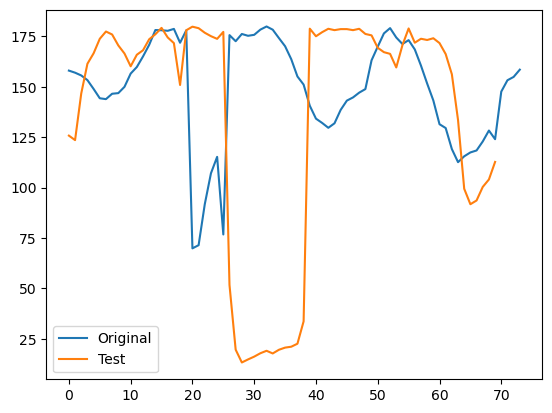

249.59741525103982 0.39904641434479066


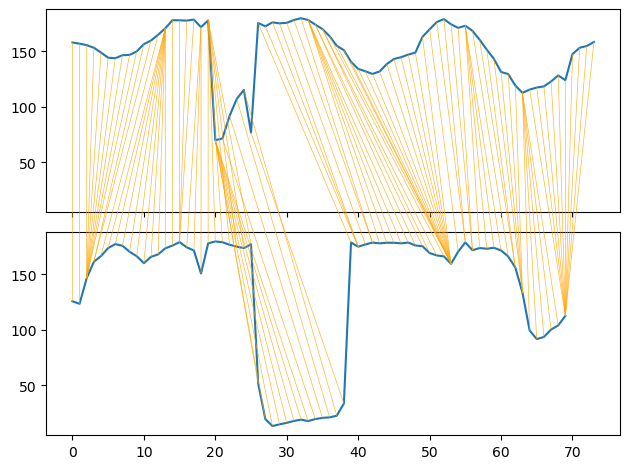

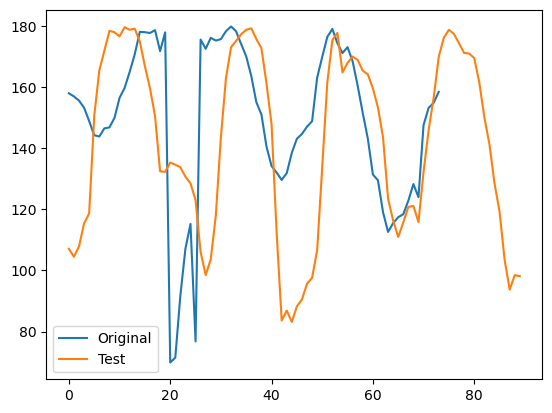

204.3172934433108 0.4870510336607887


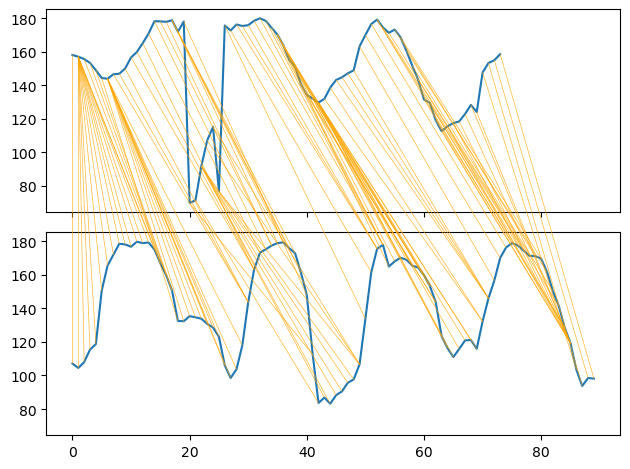

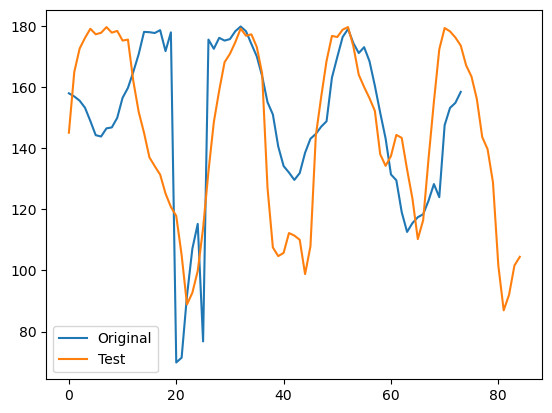

192.86308407779853 0.5158279642341259


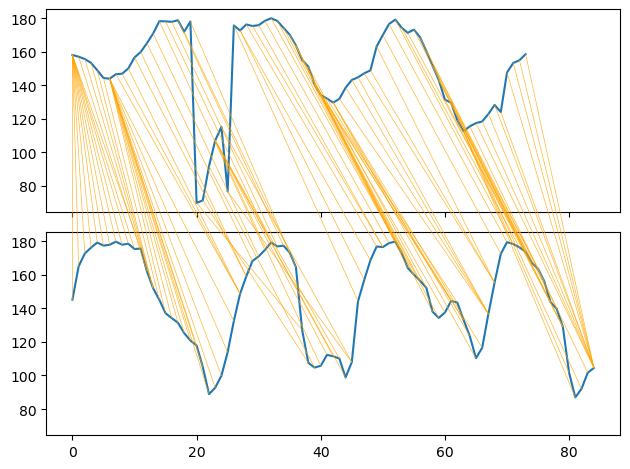

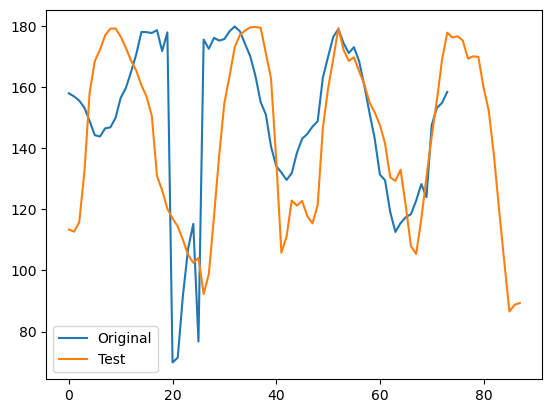

205.95712005172336 0.4831918804001896


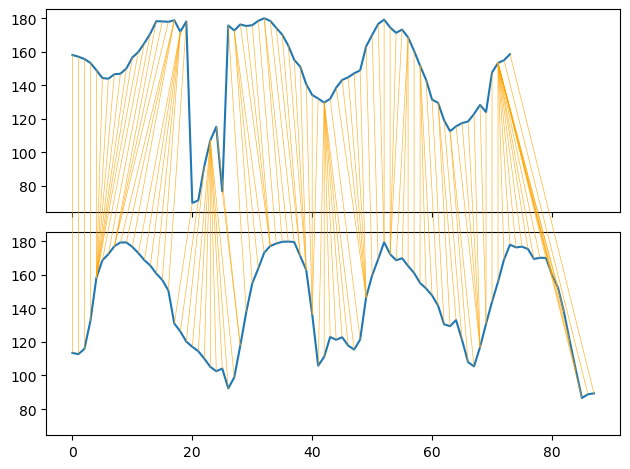

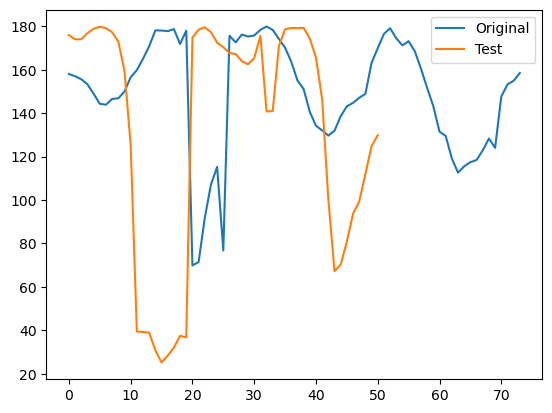

200.26941004556835 0.4968464903700941


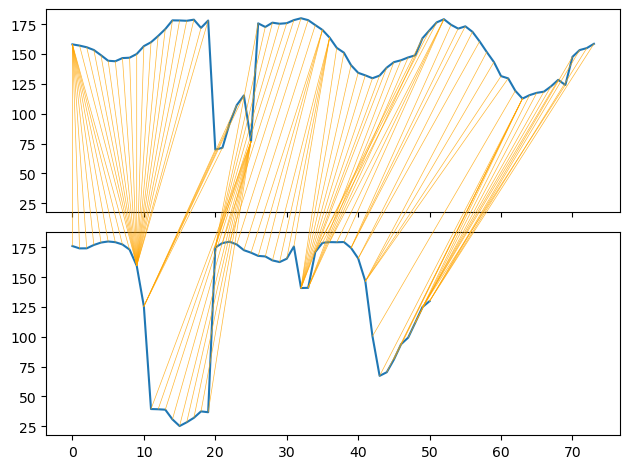

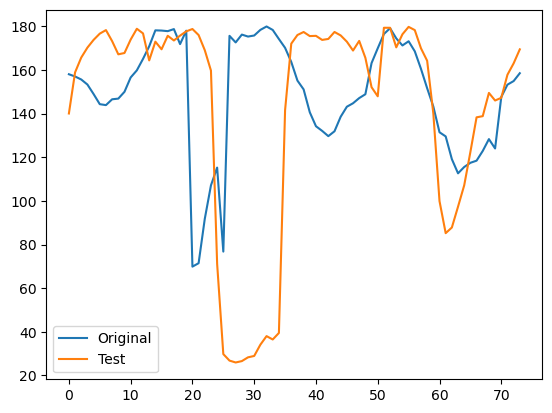

171.3859670451464 0.5800936219698838


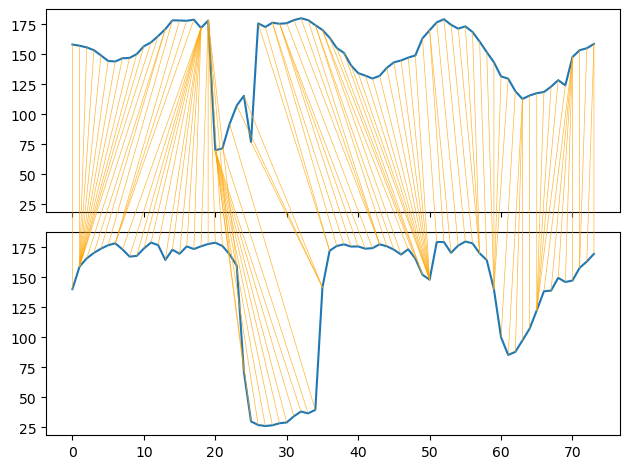

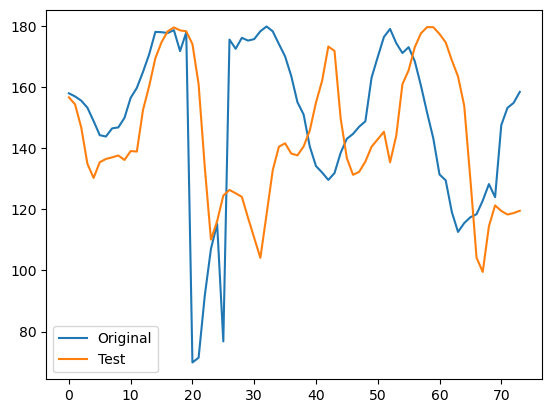

143.3650550169043 0.692688407096098


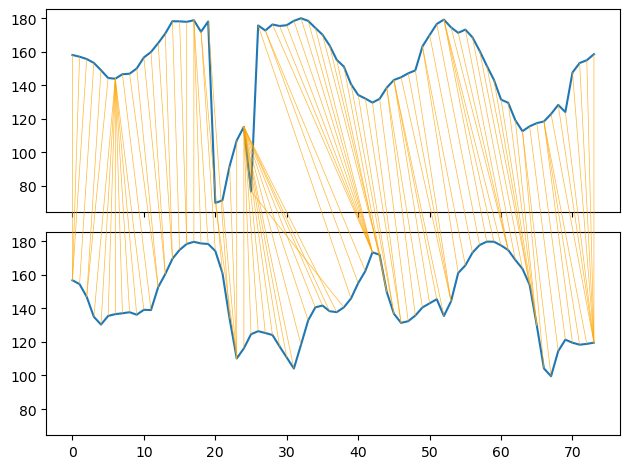

In [ ]:
# mp_drawing = mp.solutions.drawing_utils
# mp_pose = mp.solutions.pose

app_path = os.path.dirname(os.path.abspath("Yavuz_Ucarkus_152120171006_midterm_code.ipynb"))
data2_video = os.path.join(app_path, "data2 video")

veri2Path = data2_video + "/all_videos_angles.xlsx"

calculate_angles_all_videos(data2_video)
compare_datas(veri2Path)